# Disclaimer
If you use any of this for any other purpose than checking for my errors, you are insane as this is not tested.

# Useful references

* [Dmaziuk's Github page for ZHL](https://github.com/dmaziuk/diy-zhl/blob/master/diyzhl.ipynb)

* [Introductory Deco Lessons, Eric C. Baker](https://www.shearwater.com/wp-content/uploads/2012/08/Introductory-Deco-Lessons.pdf)

* [Understanding M-values, Eric C. Baker](https://www.frogkick.nl/files/understanding_m-values.pdf)

* [DIY deco, Stuart Morrison](http://www.lizardland.co.uk/DIYDeco.html)

* [Github page for SubSurface, core/deco.c](https://github.com/subsurface/subsurface/blob/master/core/deco.c)

# Schreiner Equation
## Fundamental equation of the dissolved gas

$\frac{dP}{dt} = k(P_i - P)$

For ascent or descent at a constant rate, this resolves:

$P = P_{i,0}+R\left(t-\frac{1}{k}\right)-\left[P_{i,0}-P_0-\frac{R}{k}\right]e^{-kt}$
- $P$ Final compartment inert gas pressure
- $P_{i,0}$ Initial ambient pressure
- $P_0$ Initial compartment inert gas pressure
- $R$ rate of change in inspired gas pressure with change in ambient pressure
- $t$ time
- $k$ $\frac{ln(2)}{\lambda}$
- $\lambda$: half time

This is implemented in `buhlman.get_partial_pressures()`:

In [1]:
from buhlmann import get_partial_pressures

We define the ZHL-16C coefficients

In [2]:
from buhlmann import ZHL_16C

from prettytable import PrettyTable

def generate_ascii_table(df):
    x = PrettyTable()
    x.field_names = df.columns.tolist()
    for row in df.values:
        x.add_row(row)
    print(x)
    return x

generate_ascii_table(ZHL_16C)

+-------------+-------------+--------+--------+-------------+--------+--------+
| compartment | n2_halflife |  n2_a  |  n2_b  | he_halflife |  he_a  |  he_b  |
+-------------+-------------+--------+--------+-------------+--------+--------+
|     1.0     |     5.0     | 1.1696 | 0.5578 |     1.88    | 1.6189 | 0.477  |
|     2.0     |     8.0     |  1.0   | 0.6514 |     3.02    | 1.383  | 0.5747 |
|     3.0     |     12.5    | 0.8618 | 0.7222 |     4.72    | 1.1919 | 0.6527 |
|     4.0     |     18.5    | 0.7562 | 0.7825 |     6.99    | 1.0458 | 0.7223 |
|     5.0     |     27.0    |  0.62  | 0.8126 |    10.21    | 0.922  | 0.7582 |
|     6.0     |     38.3    | 0.5043 | 0.8434 |    14.48    | 0.8205 | 0.7957 |
|     7.0     |     54.3    | 0.441  | 0.8693 |    20.53    | 0.7305 | 0.8279 |
|     8.0     |     77.0    |  0.4   | 0.891  |    29.11    | 0.6502 | 0.8553 |
|     9.0     |    109.0    | 0.375  | 0.9092 |     41.2    | 0.595  | 0.8757 |
|     10.0    |    146.0    |  0.35  | 0

Surface pressure is assumed to be 1 bar
Water Vapour Pressure in alveolis is expressed in bars

In [3]:
# in bar
SURFACE_PRESSURE = 1
WATER_VAPOR_PRESSURE_ALVEOLI = 0.0567

# in fsw
# SURFACE_PRESSURE = 33
# WATER_VAPOR_PRESSURE_ALVEOLI = 2.042


# 1st dive so 0.79 N2 and 0 HE
surface_n2_pp = 0.79


Define a gas for the dive

In [4]:
from buhlmann import Gas, Tissues
# gas = Gas(n2_pc=0.4, he_pc=0.45)
gas = Gas(n2_pc=0.79, he_pc=0.0)

initial_tissues = Tissues()
print("Initial N2 partial pressure: {}".format(initial_tissues.n2_p))
print("Initial He partial pressure: {}".format(initial_tissues.he_p))

Initial N2 partial pressure: <PandasArray>
[0.7452070000000001, 0.7452070000000001, 0.7452070000000001,
 0.7452070000000001, 0.7452070000000001, 0.7452070000000001,
 0.7452070000000001, 0.7452070000000001, 0.7452070000000001,
 0.7452070000000001, 0.7452070000000001, 0.7452070000000001,
 0.7452070000000001, 0.7452070000000001, 0.7452070000000001,
 0.7452070000000001]
Length: 16, dtype: float64
Initial He partial pressure: <IntegerArray>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 16, dtype: Int64


We define the ceiling using ZHL coefficients.
Buhlamnn used the equation of type $y= mx + b$.

But he named his coefficients such as the equation is:
$y = \frac{1}{b}x +a$

And he chose to use:
 * $P_{tissue,tol}$ on the Y-axis, tolerated inert gas in tissue
 * $P_{amb tol}$ on the X-axis, tolerated ambient pressure (absolute)
The equation is:
$P_{tissue,tol} = \frac{1}{b_{tissue}}P_{amb tol} +a_{tissue}$

So the ceiling implied from the amount of inert gas in tissue is:
$ceiling_{tissue}=P_{amb tol}=\left(P_{tissue,tol} - a_{tissue}\right) b_{tissue}$

We take the deepest ceiling of any tissue as ceiling.

We defined a function to compute this `buhlmann.ceiling(tissue)`:

In [5]:
from buhlmann import ceiling
# this will return a negative number because we are a the beginning of the dive
print("ceiling in bar is {} at the start of the dive".format(ceiling(initial_tissues)))

ceiling in bar is 0.49472300710000006 at the start of the dive


We have a function to convert this in depth:

In [6]:
from buhlmann import ceiling, pressure_to_depth, depth_to_pressure
print("ceiling in metres is {} at the start of the dive".format(
    pressure_to_depth(ceiling(initial_tissues))))

ceiling in metres is -5.052769928999999 at the start of the dive


This is how we can update the tissues across a dive:

In [7]:
import pandas as pd

dive_plan = pd.DataFrame([
    [0, 0],
    [2, 40],
    [22, 40]],
    columns=['t', 'depth'])

# create the segments from the plan
dive_plan_tuples = [(t.t, t.depth) for t in dive_plan.itertuples()]
dive_segments = zip(dive_plan_tuples[:-1], dive_plan_tuples[1:])

tissues = initial_tissues
for i_step, ((start_time, start_depth), (end_time, end_depth)) in enumerate(dive_segments):
    print("Step:{}, t_start={}, depth_start={}, t_end={}, depth_end={}".format(
        i_step, start_time, start_depth, end_time, end_depth
    ))
    tissues = get_partial_pressures(
            tissues,        # vector for compartments
            gas,
            depth_to_pressure(start_depth),    # for example 0 feet
            depth_to_pressure(end_depth),      # for example 120 feet
            end_time-start_time,              # time for depth change
    )
    print("ceiling: {}".format(pressure_to_depth(ceiling(tissues))))


Step:0, t_start=0, depth_start=0, t_end=2, depth_end=40
ceiling: -5.019497451499991
Step:1, t_start=2, depth_start=40, t_end=22, depth_end=40
ceiling: 5.5835348059744145


For the sake of convenience, we will make a function to compute the tissues and ceilings at each step:

In [8]:
from buhlmann import run_dive
updated_dive_plan = run_dive(dive_plan, initial_tissues, gas)
print(updated_dive_plan)

    t  depth                                          tissues   ceiling
0   0      0  <buhlmann.Tissues object at 0x00000271EBE3F5B0> -5.052770
1   2     40  <buhlmann.Tissues object at 0x00000271EBE6B820> -5.019497
2  22     40  <buhlmann.Tissues object at 0x00000271EBE6BB80>  5.583535


We try to find the stops for the dive

In [9]:
from buhlmann import find_next_stop, run_dive, Tissues, Gas
import pandas as pd
gas = Gas(n2_pc=0.79, he_pc=0.0)
initial_tissues = Tissues()
dive_plan = pd.DataFrame([
    [0, 0],
    [2, 40],
    [22, 40]],
    columns=['t', 'depth'])
updated_dive_plan = run_dive(dive_plan, initial_tissues, gas)

current_depth = updated_dive_plan.iloc[-1]['depth']
current_time = updated_dive_plan.iloc[-1]['t']
current_tissues = updated_dive_plan.iloc[-1]['tissues']
allstops_schedule = pd.DataFrame(
    columns=['t', 'depth', 'tissues', 'ceiling'])
while current_depth != 0:
    print("Find stops for depth={}".format(current_depth))
    stop_info = find_next_stop(current_tissues, current_depth, gas, 9)

    stop_info['t'] += current_time
    # # update the times
    # stop_info = [(current_time, current_depth)] + \
    #             [ (t +current_time, d) for (t, d) in stop_info]

    print("STOPS @ {} metres\n{}".format(current_depth, stop_info))

    # update tissues
    run_stop_schedule = run_dive(stop_info, current_tissues, gas)

    allstops_schedule = allstops_schedule.append(run_stop_schedule[1:]) # don't repeat the first entry

    # update status variables
    current_tissues = run_stop_schedule.iloc[-1]['tissues']
    current_depth = run_stop_schedule.iloc[-1]['depth']
    current_time = run_stop_schedule.iloc[-1]['t']


updated_dive_plan = updated_dive_plan.append(allstops_schedule)
print("Final Dive Plan\n{}".format(updated_dive_plan))
# we put this functionality in buhlmann.get_stops_to_surface()

Find stops for depth=40
STOPS @ 40 metres
    t  depth
0  22     40
1  26      6
Find stops for depth=6
STOPS @ 6 metres
    t  depth
0  26      6
1  40      6
2  41      0
Final Dive Plan
    t depth                                          tissues   ceiling
0   0     0  <buhlmann.Tissues object at 0x00000271EBE82670> -5.052770
1   2    40  <buhlmann.Tissues object at 0x00000271EBE828E0> -5.019497
2  22    40  <buhlmann.Tissues object at 0x00000271EBE99520>  5.583535
1  26     6  <buhlmann.Tissues object at 0x00000271EBE997C0>  4.270459
1  40     6  <buhlmann.Tissues object at 0x00000271EBE6B880> -0.086336
2  41     0  <buhlmann.Tissues object at 0x00000271EBE6BEB0> -0.263211


We provide this function to do all of this `buhlmann.get_stops_to_surface()`:

In [10]:
from buhlmann import get_stops_to_surface
from buhlmann import find_next_stop, run_dive, Tissues, Gas
import pandas as pd
gas = Gas(n2_pc=0.79, he_pc=0.0)
initial_tissues = Tissues()
dive_plan = pd.DataFrame([
    [0, 0],
    [2, 40],
    [22, 40]],
    columns=['t', 'depth'])
run_dive_plan = run_dive(dive_plan, initial_tissues, gas)
current_tissues = run_dive_plan.iloc[-1]['tissues']
current_depth = run_dive_plan.iloc[-1]['depth']
max_ascent_rate = 9 # metres/sec
run_stops = get_stops_to_surface(current_tissues, current_depth, gas, max_ascent_rate)
run_stops['t'] += run_dive_plan.iloc[-1]['t']
run_dive_plan = run_dive_plan.append(run_stops)
print(run_dive_plan)

    t  depth                                          tissues   ceiling
0   0      0  <buhlmann.Tissues object at 0x00000271EBEBD9A0> -5.052770
1   2     40  <buhlmann.Tissues object at 0x00000271EBE99310> -5.019497
2  22     40  <buhlmann.Tissues object at 0x00000271EBEBDF40>  5.583535
0  22     40  <buhlmann.Tissues object at 0x00000271EBEBDF40>  5.583535
1  26      6  <buhlmann.Tissues object at 0x00000271EBE6BE20>  4.270459
1  40      6  <buhlmann.Tissues object at 0x00000271EBE6B5B0> -0.086336
2  41      0  <buhlmann.Tissues object at 0x00000271EBE6B910> -0.263211


But to display a graph we will use the resolution parameter to run the dive

<Figure size 900x750 with 0 Axes>

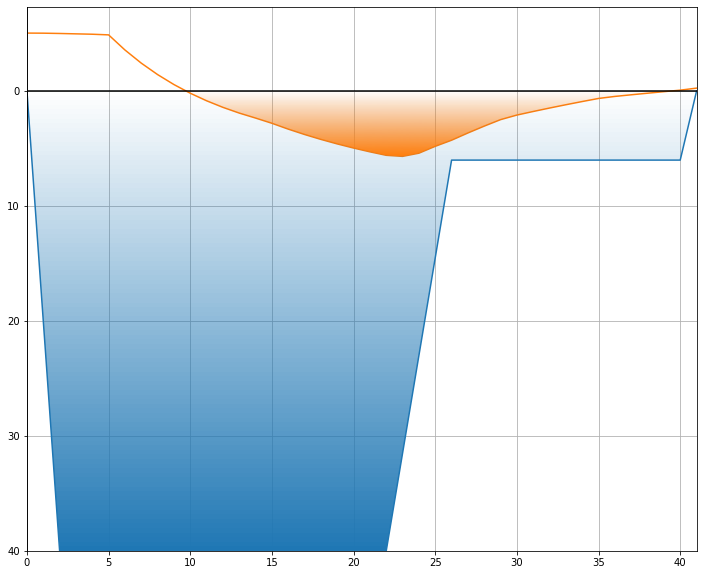

In [11]:
from buhlmann import Gas, Tissues, run_dive, get_stops_to_surface
gas = Gas(n2_pc=0.79, he_pc=0.0)
initial_tissues = Tissues()
dive_plan = pd.DataFrame([
    [0, 0],
    [2, 40],
    [22, 40]],
    columns=['t', 'depth'])
run_dive_plan = run_dive(dive_plan, initial_tissues, gas)
current_tissues = run_dive_plan.iloc[-1]['tissues']
current_depth = run_dive_plan.iloc[-1]['depth']
max_ascent_rate = 9  # metres/sec
run_stops = get_stops_to_surface(current_tissues, current_depth, gas, max_ascent_rate)
run_stops['t'] += run_dive_plan.iloc[-1]['t']
run_dive_plan = run_dive_plan.append(run_stops)

# print(run_dive_plan)
dive_data = run_dive(run_dive_plan, initial_tissues, gas, resolution=1)
# print(dive_data)

from matplotlib.patches import Polygon
import matplotlib.colors as mcolors

def gradient_fill(x, y, fill_color=None, ax=None, **kwargs):
    """
    Plot a line with a linear alpha gradient filled beneath it.

    Parameters
    ----------
    x, y : array-like
        The data values of the line.
    fill_color : a matplotlib color specifier (string, tuple) or None
        The color for the fill. If None, the color of the line will be used.
    ax : a matplotlib Axes instance
        The axes to plot on. If None, the current pyplot axes will be used.
    Additional arguments are passed on to matplotlib's ``plot`` function.

    Returns
    -------
    line : a Line2D instance
        The line plotted.
    im : an AxesImage instance
        The transparent gradient clipped to just the area beneath the curve.
    """
    if ax is None:
        ax = plt.gca()

    line, = ax.plot(x, y, **kwargs)
    if fill_color is None:
        fill_color = line.get_color()

    zorder = line.get_zorder()
    alpha = line.get_alpha()
    alpha = 1.0 if alpha is None else alpha

    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    # xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
    xmin, xmax, ymin, ymax = x.min(), x.max(), 0, y.max()
    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Polygon(xy, facecolor='none', edgecolor='none', closed=True)
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

    ax.autoscale(True)
    return line, im

%matplotlib inline
import math
import numpy as np
from matplotlib import pyplot as plt
t = np.linspace(0, 2*math.pi, 800)
a = np.sin(t)
plt.figure(figsize=(12, 10), dpi=75)
# plt.plot(dive_data['t'], dive_data['depth'], 'r')
# plt.plot(dive_data['t'], dive_data['ceiling'], 'b')
fig, ax = plt.subplots(figsize=(12,10))
gradient_fill(dive_data['t'], dive_data['depth'], ax=ax)
gradient_fill(dive_data['t'], dive_data['ceiling'], ax=ax)
plt.gca().invert_yaxis()
# ax.set_aspect('equal')
ax.grid(True, which='both')

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.show()
